In [1]:
!nvidia-smi

Sat Feb  7 01:19:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install kagglehub

In [5]:
import kagglehub

animePath = kagglehub.dataset_download("soumikrakshit/anime-faces")
print("Path to dataset files:", animePath)


Using Colab cache for faster access to the 'anime-faces' dataset.
Path to dataset files: /kaggle/input/anime-faces


In [4]:
import kagglehub
realPath = kagglehub.dataset_download("farzadnekouei/50k-celebrity-faces-image-dataset")
print("Path to dataset files:", realPath)

100%|██████████| 333M/333M [00:09<00:00, 35.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1


In [6]:
import os

print("Dataset root:", animePath)
print("Folders/files inside dataset:")
print(os.listdir(animePath))
print("Dataset root:", realPath)
print(os.listdir(realPath))


Dataset root: /kaggle/input/anime-faces
Folders/files inside dataset:
['data']
Dataset root: /root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1
['Celebrity_Faces_Dataset']


Inside data folder: ['026580.jpg', '025793.jpg', '038512.jpg', '019044.jpg', '004687.jpg', '013309.jpg', '023799.jpg', '040399.jpg', '046259.jpg', '016784.jpg', '009825.jpg', '045178.jpg', '030479.jpg', '016979.jpg', '014323.jpg', '039000.jpg', '044848.jpg', '009637.jpg', '046876.jpg', '038119.jpg', '029830.jpg', '005911.jpg', '047100.jpg', '039379.jpg', '007607.jpg', '030702.jpg', '019289.jpg', '010151.jpg', '042048.jpg', '048551.jpg', '017427.jpg', '019049.jpg', '015370.jpg', '014790.jpg', '002832.jpg', '025833.jpg', '023598.jpg', '043985.jpg', '028297.jpg', '027160.jpg', '019349.jpg', '004102.jpg', '021635.jpg', '012620.jpg', '020339.jpg', '004241.jpg', '048052.jpg', '015674.jpg', '047080.jpg', '042790.jpg', '003175.jpg', '042506.jpg', '023763.jpg', '036248.jpg', '029875.jpg', '032084.jpg', '030604.jpg', '020683.jpg', '034179.jpg', '037371.jpg', '023514.jpg', '010324.jpg', '010897.jpg', '042731.jpg', '006225.jpg', '037386.jpg', '048958.jpg', '037103.jpg', '030188.jpg', '027997.jpg',

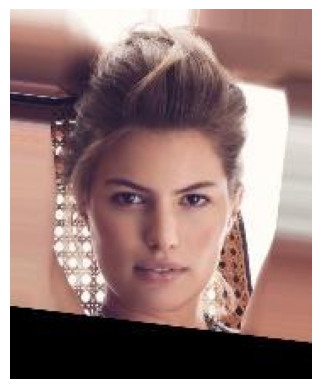

In [7]:
import os

anime_data_path = os.path.join(realPath, "Celebrity_Faces_Dataset")
print("Inside data folder:", os.listdir(anime_data_path))
anime_image_folder = os.path.join(realPath, "Celebrity_Faces_Dataset")

from PIL import Image
import matplotlib.pyplot as plt
import random
import os

anime_img_file = random.choice(os.listdir(anime_image_folder))
img = Image.open(os.path.join(anime_image_folder, anime_img_file))

plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
!pip install torch torchvision tqdm pillow matplotlib

In [11]:
#Change this directory base on above code path
ANIME_DIR="/kaggle/input/anime-faces/data"
REAL_DIR="/root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1/Celebrity_Faces_Dataset"

dataloader.py

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

class ImageDataset(Dataset):
    def __init__(self, folder):
        self.files = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".png",".jpg",".jpeg"))
        ]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return transform(img)

real_loader = DataLoader(
    ImageDataset(REAL_DIR),
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

anime_loader = DataLoader(
    ImageDataset(ANIME_DIR),
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)


generator.py

In [13]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, 1, 1),
            nn.InstanceNorm2d(c),
            nn.ReLU(True),
            nn.Conv2d(c, c, 3, 1, 1),
            nn.InstanceNorm2d(c)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(i,o):
            return nn.Sequential(
                nn.Conv2d(i,o,3,1,1),
                nn.InstanceNorm2d(o),
                nn.ReLU(True)
            )

        self.net = nn.Sequential(
            block(3,64),
            block(64,128),
            block(128,256),

            ResBlock(256),
            ResBlock(256),

            block(256,128),
            block(128,64),
            nn.Conv2d(64,3,3,1,1),
            nn.Tanh()
        )

    def forward(self,x):
        return self.net(x)


discriminator.py

In [14]:
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(i,o):
            return nn.Sequential(
                spectral_norm(nn.Conv2d(i,o,4,2,1)),
                nn.LeakyReLU(0.2,True)
            )

        self.net = nn.Sequential(
            block(3,64),
            block(64,128),
            block(128,256),
            nn.Conv2d(256,1,4,1,0)
        )

    def forward(self,x):
        return self.net(x)


GAN LOSS

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
D = Discriminator().to(device)

adv_loss = nn.MSELoss()

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5,0.999))


Perceptual Loss

In [16]:
from torchvision.models import vgg16

vgg = vgg16(weights="IMAGENET1K_V1").features[:8].eval().to(device)
for p in vgg.parameters():
    p.requires_grad = False

def gram_matrix(x):
    b, c, h, w = x.size()
    f = x.view(b, c, -1)
    return torch.bmm(f, f.transpose(1,2)) / (c*h*w)

def style_loss(fake, anime):
    f_fake = vgg(fake)
    f_anime = vgg(anime)
    return torch.mean(torch.abs(
        gram_matrix(f_fake) - gram_matrix(f_anime)
    ))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 95.3MB/s]


Edge Loss (Optional)

In [17]:
import torch.nn.functional as F

def edge_loss(fake, real):
    sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=device).float().view(1,1,3,3)
    sobel_y = sobel_x.transpose(2,3)

    def edge(img):
        gray = img.mean(1, keepdim=True)
        gx = F.conv2d(gray, sobel_x, padding=1)
        gy = F.conv2d(gray, sobel_y, padding=1)
        return torch.abs(gx) + torch.abs(gy)

    return nn.L1Loss()(edge(fake), edge(real))


Color loss

In [18]:
def color_loss(fake, real):
    return nn.L1Loss()(fake.mean([2,3]), real.mean([2,3]))

Identiy loss

In [19]:
def identity_loss(fake, real):
    return torch.mean(torch.abs(fake - real))

training.py

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.models import vgg19
from PIL import Image
import os
from itertools import cycle
from tqdm import tqdm
epochs = 15
anime_iter = cycle(anime_loader)

for epoch in range(epochs):
    for step, real_imgs in enumerate(tqdm(real_loader)):
        anime_imgs = next(anime_iter)

        real_imgs = real_imgs.to(device)
        anime_imgs = anime_imgs.to(device)

        # ===== Train G =====
        opt_G.zero_grad()

        fake = G(real_imgs)
        pred_fake = D(fake)

        loss_adv = adv_loss(pred_fake, torch.ones_like(pred_fake))
        loss_style = style_loss(fake, anime_imgs) * 3.0
        loss_id = identity_loss(fake, real_imgs) * 1.0

        loss_G = loss_adv + loss_style + loss_id
        loss_G.backward()
        opt_G.step()

        # ===== Train D  =====
        if step % 3 == 0:
            opt_D.zero_grad()

            loss_real = adv_loss(D(anime_imgs), torch.ones_like(pred_fake)*0.9)
            loss_fake = adv_loss(D(fake.detach()), torch.zeros_like(pred_fake)+0.1)

            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            opt_D.step()

    print(f"Epoch {epoch+1} | G: {loss_G.item():.3f} | D: {loss_D.item():.3f}")
    torch.save(G.state_dict(), f"G_epoch_{epoch+1}.pth")


100%|██████████| 3125/3125 [09:24<00:00,  5.53it/s]


Epoch 1 | G: 0.688 | D: 0.137


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 2 | G: 0.722 | D: 0.163


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 3 | G: 0.694 | D: 0.133


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 4 | G: 0.746 | D: 0.154


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 5 | G: 0.724 | D: 0.140


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 6 | G: 0.729 | D: 0.136


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 7 | G: 0.735 | D: 0.152


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 8 | G: 0.704 | D: 0.132


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 9 | G: 0.793 | D: 0.129


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 10 | G: 0.778 | D: 0.143


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 11 | G: 0.719 | D: 0.128


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 12 | G: 0.735 | D: 0.136


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 13 | G: 0.762 | D: 0.147


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]


Epoch 14 | G: 0.894 | D: 0.134


100%|██████████| 3125/3125 [09:29<00:00,  5.49it/s]

Epoch 15 | G: 0.815 | D: 0.121


Model loss curve

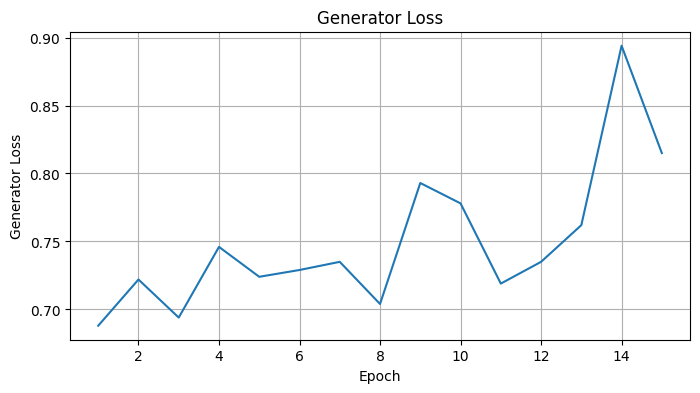

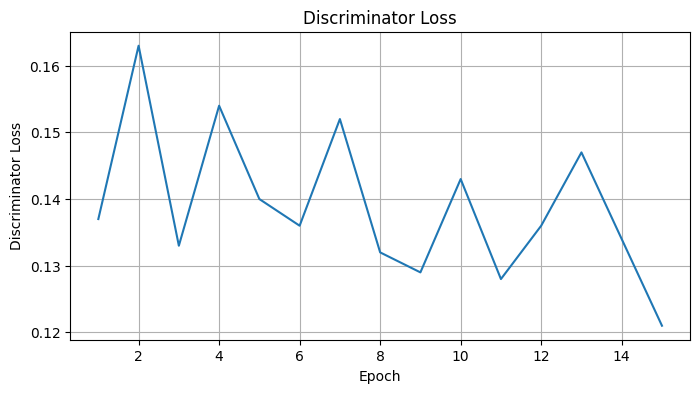

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== Load CSV =====
csv_path = "training_log.csv"
df = pd.read_csv(csv_path)

# ===== Plot =====
plt.figure(figsize=(8, 4))
plt.plot(df["Epoch"], df["G_Loss"])
plt.xlabel("Epoch")
plt.ylabel("Generator Loss")
plt.title("Generator Loss")
plt.grid(True)
plt.savefig("training_Generator_loss_curve.png", dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(df["Epoch"], df["D_Loss"])
plt.xlabel("Epoch")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss")
plt.grid(True)
plt.savefig("training_Discriminator_loss_curve.png", dpi=300)
plt.show()


test.py

In [25]:
from torchvision.utils import save_image

test_img = next(iter(real_loader)).to(device)
fake = G(test_img)

save_image(fake, "anime_result.png", normalize=True)


test_single.py

In [29]:
from PIL import Image
from torchvision import transforms
import torch

test_img_path = REAL_DIR+"/000006.jpg"

img = Image.open(test_img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

img_tensor = transform(img).unsqueeze(0).to(device)
G.eval()

with torch.no_grad():
    anime_img = G(img_tensor)
from torchvision.utils import save_image

save_image(anime_img, "single_anime_result.png", normalize=True)


Epoch Comparison

In [33]:
from PIL import Image
from torchvision import transforms
import torch

test_img_path = REAL_DIR + "/000006.jpg"

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

img = Image.open(test_img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)


In [36]:
from torchvision.utils import save_image
import os

def generate_from_epoch(epoch, save_dir):
    G.load_state_dict(
        torch.load(f"G_epoch_{epoch}.pth", map_location=device)
    )
    G.eval()
    with torch.no_grad():
        fake = G(img_tensor)
        save_image(
            fake,
            f"{save_dir}/epoch_{epoch}.png",
            normalize=True
        )


In [37]:
COMPARE_DIR = f"compare"
os.makedirs(COMPARE_DIR, exist_ok=True)

for ep in range(1, 16):
    generate_from_epoch(ep, COMPARE_DIR)

print("✅ Generated all comparison images")

✅ Generated all comparison images


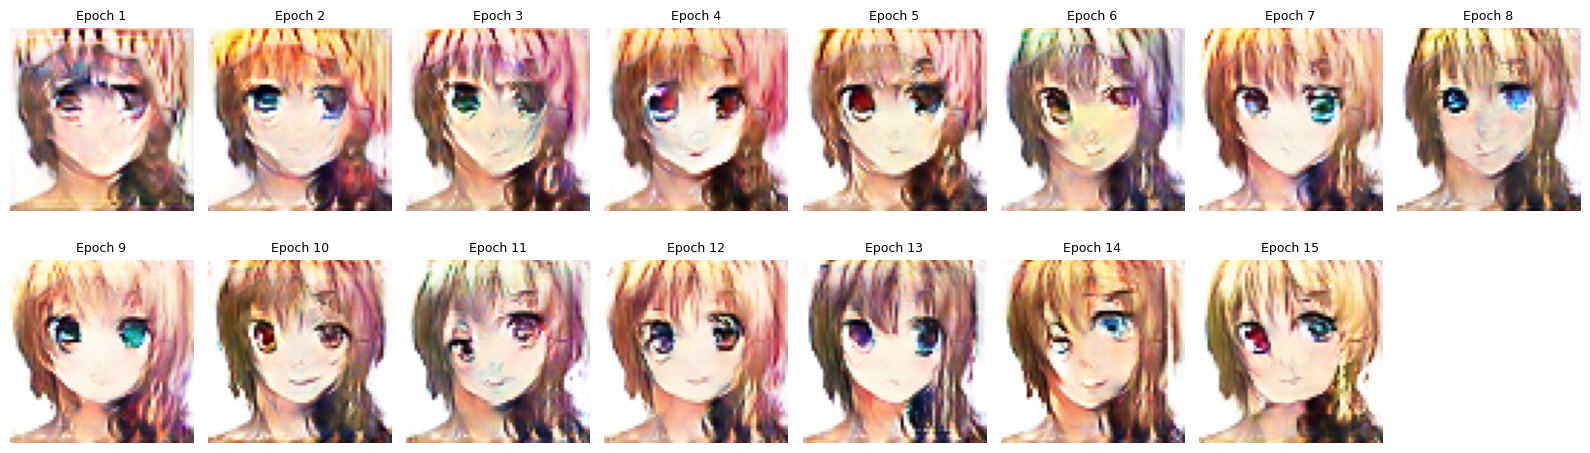

In [42]:
import matplotlib.pyplot as plt

epochs = list(range(1,16))
imgs_per_row = 8
rows = (len(epochs) + imgs_per_row - 1) // imgs_per_row

plt.figure(figsize=(imgs_per_row*2, rows*2.5))

for i, ep in enumerate(epochs):
    img = Image.open(f"{COMPARE_DIR}/epoch_{ep}.png")

    plt.subplot(rows, imgs_per_row, i+1)
    plt.imshow(img)
    plt.title(f"Epoch {ep}", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.savefig("epochsComparison.png", dpi=300)
plt.show()


Epoch determination

In [23]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

G = Generator().to(device)
G.load_state_dict(torch.load("G_epoch_10.pth", map_location=device))
G.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (3): ResBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Con

Clear cache

In [ ]:
import gc, torch

gc.collect()
torch.cuda.empty_cache()

Download result

In [41]:
!zip -r content.zip /content
from google.colab import files
files.download("content.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.12.09/ (stored 0%)
  adding: content/.config/logs/2025.12.09/14.41.33.792924.log (deflated 58%)
  adding: content/.config/logs/2025.12.09/14.41.43.412452.log (deflated 56%)
  adding: content/.config/logs/2025.12.09/14.41.42.675750.log (deflated 57%)
  adding: content/.config/logs/2025.12.09/14.41.27.893750.log (deflated 86%)
  adding: content/.config/logs/2025.12.09/14.41.18.717681.log (deflated 58%)
  adding: content/.config/logs/2025.12.09/14.40.47.605300.log (deflated 92%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  ad

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>